# Gapminder Dataset
This project works with Gapminder data that has been consolidated into a single csv dataset.
https://www.gapminder.org/data/
Specifically, the goal is to use this data to predict the life expectancy in a given country based on features such as the country's GDP, fertility rate, and population. 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# EDA

In [2]:
# Read the CSV file into a DataFrame: df
df = pd.read_csv('gm_2008_region.csv')
df.head()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5,Middle East & North Africa
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0,Sub-Saharan Africa
2,40381860.0,2.24,0.5,4.785170,27.50170,14646.0,118.8915,75.5,15.4,America
3,2975029.0,1.40,0.1,1.804106,25.35542,7383.0,132.8108,72.5,20.0,Europe & Central Asia
4,21370348.0,1.96,0.1,18.016313,27.56373,41312.0,117.3755,81.5,5.2,East Asia & Pacific


In [3]:
# see the shape and data types of the dataframe 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 10 columns):
population         139 non-null float64
fertility          139 non-null float64
HIV                139 non-null float64
CO2                139 non-null float64
BMI_male           139 non-null float64
GDP                139 non-null float64
BMI_female         139 non-null float64
life               139 non-null float64
child_mortality    139 non-null float64
Region             139 non-null object
dtypes: float64(9), object(1)
memory usage: 11.0+ KB


The DataFrame has 139 samples (or rows) and 9 columns.
The attributes in this dataset are:
+ Population: total population
+ Fertility: total fertility rate, number of babies born to each woman
+ HIV: estimated adults ages 15-49 infected with HIV
+ CO2: Carbond Dioxide emissions in tonnes per person
+ BMI_male: Mean BMI of the male population in kilogram per square meter
+ GDP: Total GDP
+ BMI_female: Mean BMI of the female population in kilogram per square meter
+ Child Mortality: Death of children under 5 years of age per 1,000 live births
+ Region: Geographical region
The target variable is **life expectancy**

I am concerned about the B column: https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8

Since the target variable life expectancy is quantitative, this is a **regression problem**. There are 9 predictors, 8 of those are numeric floats. There is one categorical predictor for Region. 

In [4]:
# look at the basic statistics of the numeric data
df.describe()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality
count,1.390000e+02,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,3.549977e+07,3.005108,1.915612,4.459874,24.623054,16638.784173,126.701914,69.602878,45.097122
std,1.095121e+08,1.615354,4.408974,6.268349,2.209368,19207.299083,4.471997,9.122189,45.724667
min,2.773150e+05,1.280000,0.060000,0.008618,20.397420,588.000000,117.375500,45.200000,2.700000
25%,3.752776e+06,1.810000,0.100000,0.496190,22.448135,2899.000000,123.232200,62.200000,8.100000
50%,9.705130e+06,2.410000,0.400000,2.223796,25.156990,9938.000000,126.519600,72.000000,24.000000
75%,2.791973e+07,4.095000,1.300000,6.589156,26.497575,23278.500000,130.275900,76.850000,74.200000
max,1.197070e+09,7.590000,25.900000,48.702062,28.456980,126076.000000,135.492000,82.600000,192.000000


The mean life expectancy is 69.602878. 

## Create Feature and Target Arrays
To begin, we will fit a linear regression with just one feature: 'fertility', which is the average number of children a woman in a given country gives birth to. 

In [5]:
# Create arrays for features and target variable
y = df['life'].values
X_fertility = df['fertility'].values

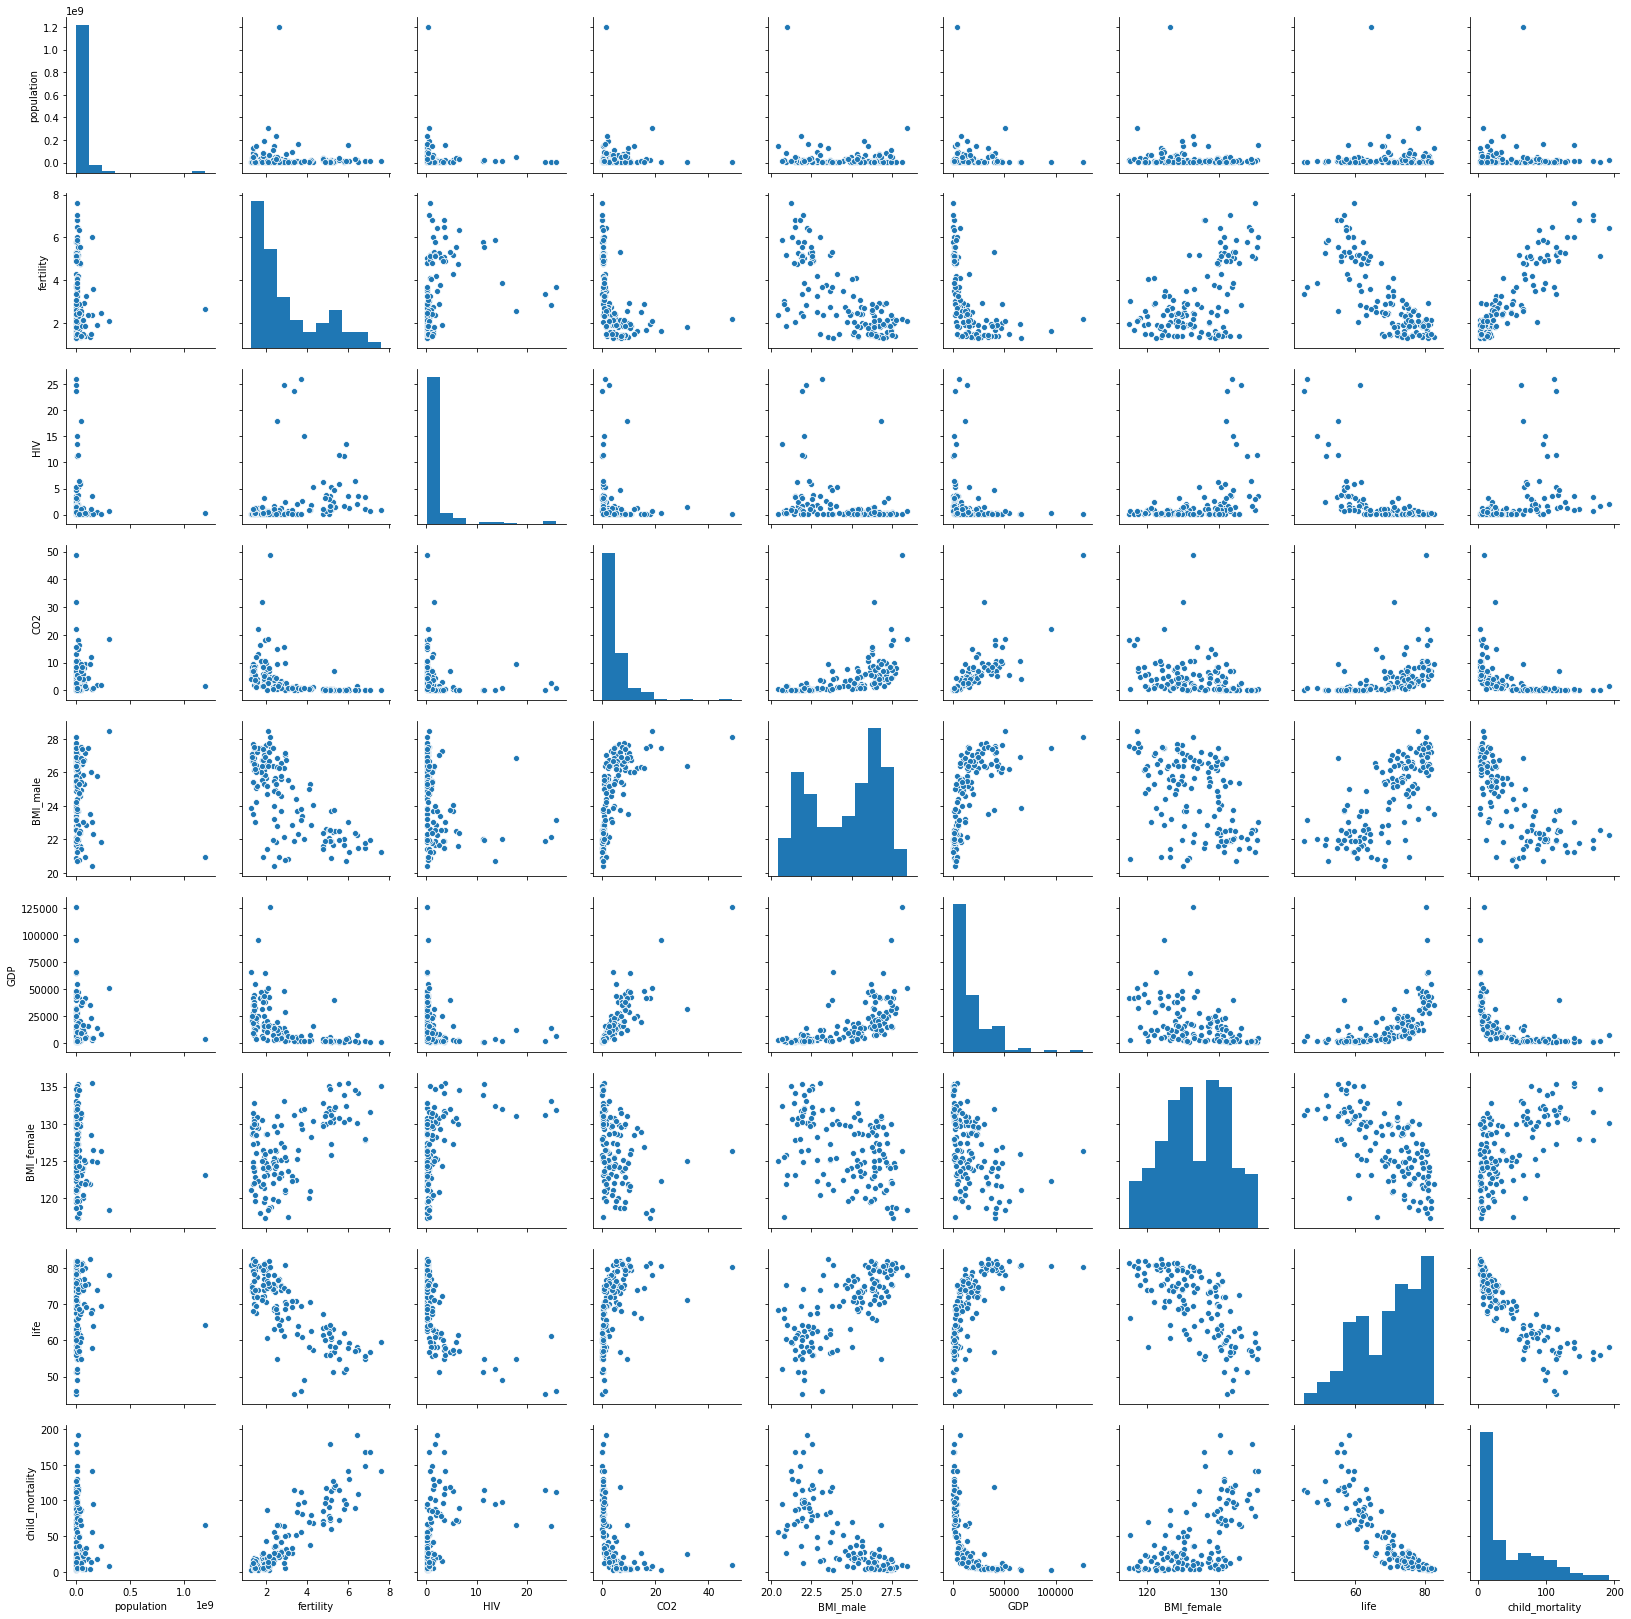

In [6]:
# create pairplots of all numeric factors in the dataset 
sns.pairplot(df)

From the scatterplot matrix, it looks like some features have fertility and child mortality have strong linearity. The target variable life expectancy also shows strong linearity with features like child mortality and fertility. To explore this further, we can create a correlation heatmap. 

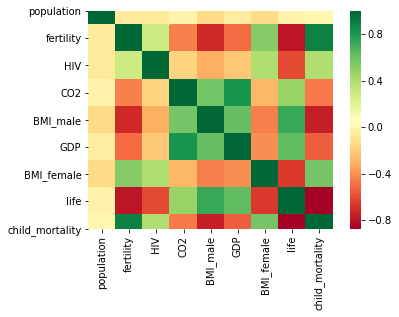

In [7]:
# create a correlation heatmap 
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

Cells that are in green show positive correlation, while cells that are in red show negative correlation.Life expectancy is positvely correlated with GDP, BMI_male, and CO2. Life expectancy is negatively correlated with BMI_female, HIV, and fertility. My intuition is that life expectancy would be associated with higher GDP and carbon dioxide emissions per person. Life expectancy being associated with the male population having a higher mean BMI is somewhat surprising. For BMI, a higher mean BMI for females is associated with lower life expectancy. I expected HIV to be negatively correlated with life expectancy. It will be interesting to further explore the relationship between fertility and life expectancy.

## Predicting Life Expectancy from a Single Feature

We want to fit a line to the data. A line in two dimensions is always in the form y = ax + b where y is the target, x is the single feature, and a,b are the parameters of the model that we want to learn. The question is how we choose a and b. A common method is to choose an error function for any given line and choose the line that minimizes the error function. We want the line to be as close to the data points as possible. We want to minimize the vertical distance between the points (the residual) and the line. We minimize the sum of squares of the residuals so that a large negative residual doesn't cancel out a large positive residual. This loss function is called **Ordinary Least Squares (OLS)**. This is the same as minimizing the **Mean Squared Error** of the predictions on the training set. We can also do linear regression in higher dimensions.

In [8]:
# Print the dimensions of X and y before reshaping
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X_fertility.shape))

Dimensions of y before reshaping: (139,)
Dimensions of X before reshaping: (139,)


In [9]:
# make sure that these are numpy arrays
type(X_fertility), type(y)

(numpy.ndarray, numpy.ndarray)

In [10]:
# Reshape X and y
# into proper format for scikit-learn
y = y.reshape(-1,1)
X_fertility = X_fertility.reshape(-1,1)

In [11]:
# Print the dimensions of X and y after reshaping
print("Dimensions of y after reshaping: {}".format(y.shape))
print("Dimensions of X_fertility after reshaping: {}".format(X_fertility.shape))

Dimensions of y after reshaping: (139, 1)
Dimensions of X_fertility after reshaping: (139, 1)


In [12]:
# create the regressor: reg
reg = LinearRegression()

In [13]:
# Create the prediction space
prediction_space = np.linspace(min(X_fertility), max(X_fertility)).reshape(-1,1)

In [14]:
# Fit the model to the data
reg.fit(X_fertility, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

In [16]:
# Print R^2 
print(reg.score(X_fertility, y))

0.6192442167740037


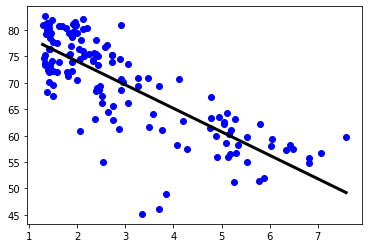

In [17]:
# Plot regression line
plt.scatter(X_fertility, y, color='blue')
plt.plot(prediction_space, y_pred, color='black', linewidth=3)
plt.show()

We can see from the R-squared value of 0.6192 that the linear regression line with the single fertility predictor does an alright (but not perfect) job fitting the data. We would almost never use linear regression straight out of the box like this without regularization which places further constraints on the model coefficients. 

## Predict Life Expectancy from All Features

In [18]:
# Create arrays for the features and the response variable
# for now I am dropping region because it is an object instead of a numeric value
# TODO: encode region as a dummy variable 
y = df['life'].values
X = df.drop(['life', 'Region'], axis=1).values

In [19]:
# Create training and test sets
# sklearn train_test_split randomly splits dataset
# into training set and testing set 
# in this case, we are using 30% of the dataset for a test set 
# random_state=42 sets seed 
# this means we can reproduce the exact split and downstream results later
# stratify=y means that labels will be distributed in the train/test datasets
# as they are in the full dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [20]:
# Create the regressor: reg_all
reg_all = LinearRegression()

In [21]:
# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

In [23]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.8380468731430055
Root Mean Squared Error: 3.2476010800370254


The root mean squared error is a measure of how well the model performed. It does this by measuring the difference between predicted values and the actual values. The error term is important because we want to minimize the error. In other words, our predictions are close to the actual value. ***RMSE*** penalizes large errors more.  

## Cross-validation
If we compute R-squared on our test set, the result is dependent on how the model was split. The dataset could have been split into a training and test set in such a way that the training and test sets have some quirks. The R-squared value computed on a particular training and test set might not be representative of the model's ability to generalize. With 5-fold Cross-validation, we split the dataset into five folds. We have five splits where we hold back a fold as a test set and train on the other four folds so that by the end of the process, each fold has been the test set in a split. We can compute the mean and median as well as confidence intervals for the R-squared results from these splits. Using more folds is more computationally expensive.

In [24]:
# Create a linear regression object: reg
reg = LinearRegression()

In [25]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, y, cv=5)

In [26]:
# Print the 5-fold cross-validation scores
print(cv_scores)

[0.81720569 0.82917058 0.90214134 0.80633989 0.94495637]


In [27]:
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 5-Fold CV Score: 0.8599627722793801
